# Differential expression analysis

Differential gene expression analysis is a statistical method to identify genes that are upregulated or downregulated between different conditions or samples, in other words "differentially expressed". 

For example, we may expect inflammatory genes to be more highly expressed, or upregulated, in macrophages treated with a bacterial toxin. Another example could be the downregulation, or decrease in expression, of Pax7 during differentiation from myoblasts to myotubes, like in C2C12 cells.


In [1]:
# Load some libraries
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pandas as pd
import numpy as np
from adjustText import adjust_text
import matplotlib.pylab as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read in metadata file; only really care about certain columns for plotting purposes
metadata = pd.read_csv("/data/class/cosmos2023/PUBLIC/ta-github/data/fshd_metadata.csv", 
                       usecols=['Run', 'Sample', 'Individual', 'fshd_status', 'day_of_differentiation'])

# Construct data frame

Most DEG software tools require non-normalized (raw) counts as input. We were working with the normalized matrix for plotting PCA and heatmaps, but need to construct the counts matrix. This is the same code as in `python_analysis.ipynb`, except we extract the `est_counts` column rather than `tpm` and use unique `gene_id` rather than `gene_name`.

In [3]:
# Directory containing the output folders 
output_dir = '../kallisto_output'

# List to store individual dataframes
dfs = []


In [4]:
# Loop through each folder in the output directory
for folder in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder)
    file_path = os.path.join(folder_path, 'gene_abundance.tsv')

    # Read gene_abundance.tsv as a dataframe
    df = pd.read_csv(file_path, sep ='\t')
    counts_col = df['est_counts']  # Extract counts column
    dfs.append(counts_col) # Add gene expression measurements from each sample to a growing list
    
# Create a dataframe from the list of measurements from all the samples
merged_df = pd.concat(dfs, axis=1)
merged_df.columns = os.listdir(output_dir)  # Assign sample names as column names

# Create a dictionary mapping Run to Sample from the metadata
column_mapping = dict(zip(metadata['Run'], metadata['Sample']))

# Rename the columns using the mapping
merged_df.rename(columns=column_mapping, inplace=True)

# Reorder columns (not necessary, just makes it nicer to look at)
column_order = ['Control-1 Day 3 Rep 1', 'Control-1 Day 3 Rep 2', 
                'Control-1 Day 5 Rep 1', 'Control-1 Day 5 Rep 2', 
                'FSHD2-1 Day 3 Rep 1', 'FSHD2-1 Day 3 Rep 2', 
                'FSHD2-1 Day 5 Rep 1', 'FSHD2-1 Day 5 Rep 2']
merged_df = merged_df.reindex(columns=column_order)

# Set index (like row names) to be the gene id
merged_df = merged_df.set_index(df['gene_id'])

# drop unexpressed genes
merged_df = merged_df.loc[merged_df.sum(axis=1) != 0]

# Write the merged dataframe to a new file
merged_df.to_csv('data/counts_matrix.tsv', sep='\t', index=False)


# Format metadata 
Rows of metadata must exactly match the columns in the final dataframe.

In [5]:
# Filter metadata DataFrame based on matching samples in merged_df
metadata_filtered = metadata[metadata['Sample'].isin(merged_df.columns)].copy()

# Sort filtered_metadata based on the order of columns in merged_df
metadata_filtered['Sample'] = pd.Categorical(metadata_filtered['Sample'], categories=merged_df.columns)
metadata_filtered.sort_values('Sample', inplace=True)


# Define filters and group

To perform DEG analysis, you must choose a condition to test. For example, control vs. FSHD, or one timepoint vs. another. Here, I'm testing Control Day 3 vs. Day 5 cells.

In [6]:
filtering = {'fshd_status': ['Control'],#,'FSHD2'],
             'day_of_differentiation': ['Day 3','Day 5']}
group = 'day_of_differentiation' # change to the group you're interested in making the comparison in


In [7]:
metadata_selected = metadata_filtered.copy(deep=True)
for col in filtering.keys():
    metadata_selected = metadata_selected[metadata_selected[col].isin(filtering[col])]

metadata_selected.index = metadata_selected['Sample']
merged_df_selected = merged_df.loc[:, metadata_selected['Sample']]
merged_df_selected[merged_df_selected.columns] = merged_df_selected[merged_df_selected.columns].astype(int)



In [8]:
metadata_selected

,Run,day_of_differentiation,fshd_status,Sample,Individual
Sample,,,,,
Control-1 Day 3 Rep 1,SRR10870729,Day 3,Control,Control-1 Day 3 Rep 1,Control-1
Control-1 Day 3 Rep 2,SRR10870730,Day 3,Control,Control-1 Day 3 Rep 2,Control-1
Control-1 Day 5 Rep 1,SRR10870733,Day 5,Control,Control-1 Day 5 Rep 1,Control-1
Control-1 Day 5 Rep 2,SRR10870734,Day 5,Control,Control-1 Day 5 Rep 2,Control-1


# Run PyDESeq2
See package documentation [here](https://pydeseq2.readthedocs.io/en/latest/).

The output of this method is a list of genes with associated statistical measurements such as **fold change** and **adjusted p-value**. 

Imagine the average expression of Pax7 in myoblasts (MB) is 100 TPM and in myotubes (MT) it's 1.5 TPM. To calculate the fold change in MT vs. MB, divide the average expression in MT by the average expression in MB: 1.5 TPM ÷ 100 TPM = 0.015.

The fold change is log2-transformed for plotting purposes. Any fold change less than 0 results in a negative log fold change. For example, log2(0.015) = -6.

A p-value is basically a measure that tells us how likely an observed result occurred by chance alone. If the p-value is low (e.g., less than 0.05), it suggests that the result is unlikely to have occurred by chance. On the other hand, if the p-value is high (e.g., greater than 0.05), it suggests that the observed result could have reasonably occurred by chance alone.

p-values are also often log-transformed for plotting purposes, but since they can be very small, we transform them by -log10. For example, a p-value of 0.00001 is transformed by -log10(0.00001) = 5. 

The "adjusted" in "adjusted p-value" refers to controlling for false positives. Since thousands of genes are tested simultaneously in DEG analysis, performing multiple hypothesis tests without any correction would increase the risk of false positives (Type I errors). Without adjustment, the probability of obtaining some statistically significant results by chance alone would be high.

In [9]:
dds = DeseqDataSet(
    counts=merged_df_selected.T,
    clinical=metadata_selected,
    design_factors=group,
    refit_cooks=True
)
dds.deseq2()
stat_res = DeseqStats(dds, 
                      contrast=[group] + filtering[group])
stat_res.summary()

Fitting size factors...
... done in 0.01 seconds.



/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Fitting dispersions...
... done in 16.83 seconds.

Fitting dispersion trend curve...
... done in 23.59 seconds.

Fitting MAP dispersions...
... done in 13.07 seconds.

Fitting LFCs...
... done in 3.50 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 3.84 seconds.

Log2 fold change & Wald test p-value: day_of_differentiation Day 3 vs Day 5


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSG00000223972.5,2.081473,-0.910079,1.891332,-0.481184,0.630386,NaN
ENSG00000227232.5,20.101891,-0.290715,0.582639,-0.498963,0.617806,0.774913
ENSG00000233750.3,38.429230,-0.227524,0.418646,-0.543476,0.586802,0.750883
ENSG00000268903.1,0.970093,-0.290027,3.173542,-0.091389,0.927184,NaN
ENSG00000269981.1,0.268263,-1.667682,5.343856,-0.312075,0.754984,NaN
...,...,...,...,...,...,...
ENSG00000277196.4,6.135505,-4.692156,1.715515,-2.735129,0.006236,0.022399
ENSG00000278384.1,3.509186,-0.659081,1.348648,-0.488698,0.625055,NaN
ENSG00000276345.1,0.000000,NaN,NaN,NaN,NaN,NaN


# Set cutoffs to display on plot


In [10]:
l2fc_cutoff = 1 # Log 2 fold change; usually 0.5 - 2
pval_cutoff = 0.01 # 0.01 is even better than 0.05


# Format results

In [11]:
annot = pd.read_csv("/data/class/cosmos2023/PUBLIC/ref/homo_sapiens/transcripts_to_genes.txt",sep="\t",header=None)
annot = pd.read_csv("/data/class/cosmos2023/PUBLIC/ref/homo_sapiens/transcripts_to_genes.txt",sep="\t",
                    header=None,names=['transcript_id', 'gene_id', 'gene_name'])

annot = annot[["gene_id", "gene_name"]]
annot = annot.drop_duplicates()


In [12]:
df = stat_res.results_df.copy(deep=True)

# Find the machine-specific lowest non-zero value
lowest_nonzero_value = df['padj'][df['padj'] > 0].min()

# Replace 0 with the lowest non-zero value
df['padj'] = np.where(df['padj'] == 0, lowest_nonzero_value, df['padj'])

df = df.dropna()
df = df.merge(annot, left_index=True, right_on='gene_id')

# Calculate -log10(padj)
df['nlog10padj'] = -np.log10(df['padj'])

# Add labels to DE column based on our cutoffs above
df['DE'] = "No"
df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange > l2fc_cutoff)] = "Up"
df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange < -l2fc_cutoff)] = "Down"

/tmp/ipykernel_1805685/511987340.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange > l2fc_cutoff)] = "Up"
/tmp/ipykernel_1805685/511987340.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DE[np.logical_and(df.padj < pval_cutoff, df.log2FoldChange < -l2fc_cutoff)] = "Down"


# Make volcano plot from DEG results

/tmp/ipykernel_1805685/988295965.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.label[df.DE == "No"] = ""
/tmp/ipykernel_1805685/988295965.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down.sort_values(["padj"], inplace=True)
/tmp/ipykernel_1805685/988295965.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up.sort_values(["padj"], inplace=True)


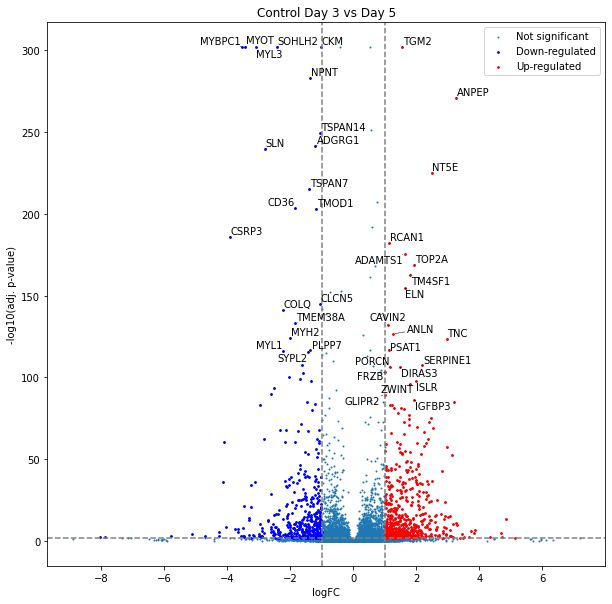

In [13]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

df['label'] = df.gene_name
df.label[df.DE == "No"] = ""

# Create the figure
fig, ax = plt.subplots()

# Set the figure size
fig.set_size_inches(10, 10)

# Plot whole df first (with small size dots)
ax.scatter(x=df['log2FoldChange'], y=df['nlog10padj'], s=1, label="Not significant")

# Highlight up- or down-regulated genes
down = df[df.DE == "Down"]
down.sort_values(["padj"], inplace=True)
up = df[df.DE == "Up"]
up.sort_values(["padj"], inplace=True)

# Overlay up- and down-regulated gene dfs with larger label and specific color
ax.scatter(x=down['log2FoldChange'], y=down['nlog10padj'], s=3, label="Down-regulated", color="blue")
ax.scatter(x=up['log2FoldChange'], y=up['nlog10padj'], s=3, label="Up-regulated", color="red")

# Display names of top 20 up- or down-regulated genes
n_genes = 20
texts = []
for i in range(min(n_genes, up.shape[0])):
    texts.append(ax.text(x=up.iloc[i, 1],
                         y=up.iloc[i, 8],
                         s=up.iloc[i, 7]))
for i in range(min(n_genes, down.shape[0])):
    texts.append(ax.text(x=down.iloc[i, 1],
                         y=down.iloc[i, 8],
                         s=down.iloc[i, 7]))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Draw lines indicating lfc and padj cutoffs
ax.set_xlabel("logFC")
ax.set_ylabel("-log10(adj. p-value)")
ax.axvline(l2fc_cutoff, color="grey", linestyle="--")
ax.axvline(-l2fc_cutoff, color="grey", linestyle="--")
ax.axhline(-np.log10(pval_cutoff), color="grey", linestyle="--")

# Draw legend
ax.legend()

# Add a title to the plot
ax.set_title("Control Day 3 vs Day 5")

# Save the plot as a high-resolution PNG with specific width and height
output_file = "volcano_plot.png"
plt.savefig(output_file, dpi=300)

# Show the plot
plt.show()


# Save results as a csv file

In [14]:
df = df.drop(['DE', 'label'], axis=1) # drop columns that were just for plotting purposes

df.to_csv('deg_results.csv', index=False)